# Import libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
import os

# Input file

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
os.chdir('/content/drive/My Drive/Kaggle')
os.getcwd()

'/content/drive/My Drive/Kaggle'

In [57]:
input_file = pd.read_csv('train.csv')

In [58]:
input_file.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

Let's see if passenger class has any impact on the sruvival

In [59]:
input_file.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [60]:
input_file['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

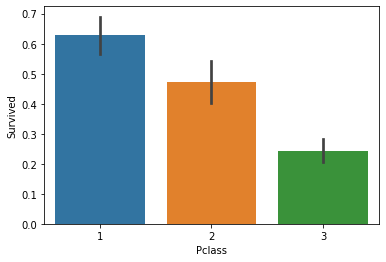

In [61]:
sns.barplot('Pclass','Survived',data=input_file);

We can clearly see that passenger class does have an impact on the survival

Let's now see if gender impacted the survival

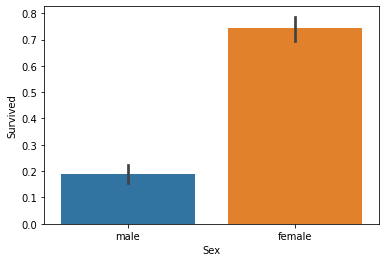

In [62]:
sns.barplot('Sex','Survived',data=input_file);

Gender does have an impact on survival

Let's now see the impact of age on survival

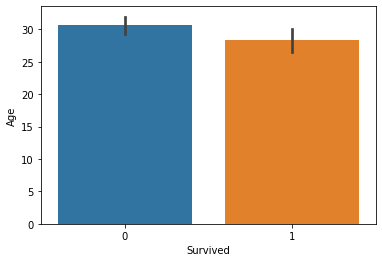

In [63]:
sns.barplot('Survived','Age',data=input_file);

The age of those survived was on an average slightly less than that of those who didn't survive

Let's now look at the impact of siblings and spouse and parents and children on survival

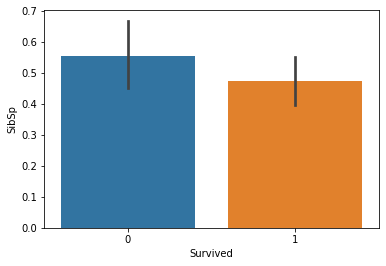

In [64]:
sns.barplot('Survived','SibSp',data=input_file);

The people who survived had fewer siblings and spouses than those who didn't survive

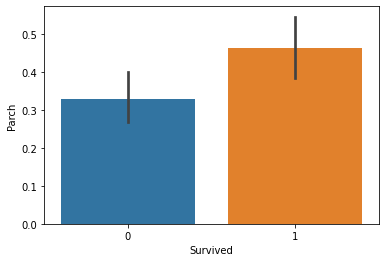

In [65]:
sns.barplot('Survived','Parch',data=input_file);

The people who survived had more parents and children than those who didn't survive

Let's next look at Fare variable

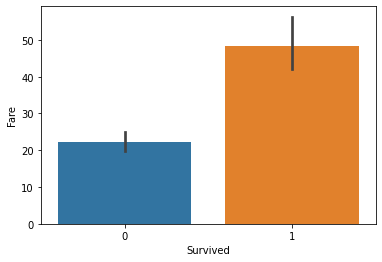

In [66]:
sns.barplot('Survived','Fare',data=input_file);

The people who survived paid a higher fare than those who didn't

Let's now look at Embarked

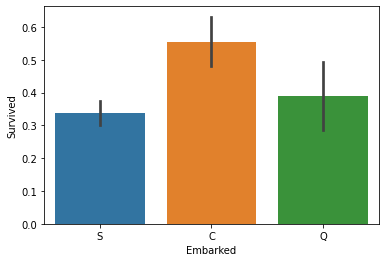

In [67]:
sns.barplot('Embarked','Survived',data=input_file);

We can see that embarked does have an impact on survival

Let's next build a pipeline that takes care of preprocessing of the input file

In [158]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import MinMaxScaler

In [159]:
class PreProcess(BaseEstimator, TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        df = X.copy()
        
        # We will drop cols that don't add value
        drop_cols = ['PassengerId','Ticket','Cabin']
        df.drop(drop_cols,axis=1,inplace=True)
        
        # Let's impute the cols with missing vals
        df['Age'] = df['Age'].fillna(df['Age'].mean())
        df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
        
        #Let's process the name variable

        def title_clean(x):
          if x in ["Mr.","Miss.","Mrs.","Master."]:
            return x
          else:
            return "Others."

        df['Name'] = df['Name'].apply(lambda x:x.split(',')[1].split()[0])
        df['Name'] = df['Name'].apply(title_clean)

        #Let's now one hot encode the cat variables
        df = pd.get_dummies(df,columns=['Sex','Embarked','Name'])

        #Normalize
        #df['Age'] = np.log(df['Age']+10)
        df['Fare'] = np.log(df['Fare']+10)

        df = MinMaxScaler().fit_transform(df)
        
        return df

Train test split

In [160]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [161]:
X = input_file.drop('Survived',axis=1)
y = input_file['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [162]:
preprocess = PreProcess()

In [163]:
preprocess.fit_transform(X_train)

array([[0.        , 0.67328474, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.36574495, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.5       , 0.30887158, 0.125     , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.50992712, 0.25      , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.17064589, 0.125     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.25860769, 0.        , ..., 1.        , 0.        ,
        0.        ]])

Let's now start building models

In [164]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression

In [165]:
from sklearn.linear_model import LogisticRegression

In [166]:
pipe_lr = Pipeline([('pre',PreProcess()),('lr',LogisticRegression(random_state=42))])

In [167]:
param_lr = {'lr__C':[.001, 0.01, 0.1, 1, 10, 100]}

In [168]:
grid_lr = GridSearchCV(pipe_lr,param_grid=param_lr)

In [169]:
grid_lr.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           rand

In [170]:
grid_lr.best_params_

{'lr__C': 1}

In [171]:
grid_lr.best_score_

0.8138655462184874

# Naive Baye's

In [172]:
from sklearn.naive_bayes import GaussianNB

In [173]:
pipe_nb = Pipeline([('pre',PreProcess()),('nb',GaussianNB())])

In [174]:
pipe_nb.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('pre', PreProcess()),
                ('nb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [175]:
print(pipe_nb.score(X_train,y_train))
print(pipe_nb.score(X_test,y_test))

0.7969798657718121
0.8033898305084746


Naive baye's performed slightly better

# Support Vector Machines

In [176]:
from sklearn.svm import SVC

In [177]:
pipe_svc = Pipeline([('pre',PreProcess()),('svc',SVC(random_state=42))])

In [178]:
param_svc = {'svc__C':[.001, 0.01, 0.1, 1, 10, 100],'svc__gamma':[.001, 0.01, 0.1, 1, 10, 100]}

In [179]:
grid_svc= GridSearchCV(pipe_svc,param_grid=param_svc)

In [180]:
grid_svc.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False, random_state=42,
                                            shrinking=True, tol=0.001,
                                            verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                 

In [181]:
grid_svc.best_params_

{'svc__C': 10, 'svc__gamma': 0.1}

In [182]:
grid_svc.best_score_

0.8356442577030812

# KNN

In [183]:
from sklearn.neighbors import KNeighborsClassifier

In [184]:
pipe_knn = Pipeline([('pre',PreProcess()),('knn',KNeighborsClassifier())])

In [185]:
param_knn = {'knn__n_neighbors':[1,2,3,4,5,6,7,8,9,10],'knn__weights':['uniform', 'distance'],'knn__metric':['manhattan','minkowski','euclidean']}

In [186]:
grid_knn= GridSearchCV(pipe_knn,param_grid=param_knn)

In [187]:
grid_knn.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'knn__metric': ['manhattan', 'minkowski', 'euclidean'],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  

In [188]:
grid_knn.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'uniform'}

In [189]:
grid_knn.best_score_

0.8288935574229692

# Decision Tree

In [111]:
from sklearn.tree import DecisionTreeClassifier

In [112]:
pipe_dt = Pipeline([('pre',PreProcess()),('dt',DecisionTreeClassifier())])

In [113]:
param_dt = {'dt__criterion':["gini", "entropy"],'dt__max_depth':[1,2,3,4,5,6,7,8],
            'dt__min_samples_split':[1,2,3,4,5],
            'dt__min_samples_leaf':[1,2,3,4,5,6],
            'dt__class_weight':["balanced",None]}

In [114]:
grid_dt= GridSearchCV(pipe_dt,param_grid=param_dt)

In [115]:
grid_dt.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                             

In [116]:
grid_dt.best_params_

{'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': 7,
 'dt__min_samples_leaf': 5,
 'dt__min_samples_split': 2}

In [117]:
grid_dt.best_score_

0.8204901960784312

# Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier

In [119]:
pipe_rf = Pipeline([('pre',PreProcess()),('rf',RandomForestClassifier(random_state=42))])

In [120]:
param_rf = {'rf__criterion':["gini", "entropy"],'rf__max_depth':[1,2,3,4,5,6,7,8],
            'rf__min_samples_split':[1,2,3,4,5],
            'rf__min_samples_leaf':[1,2,3,4,5,6],
            'rf__class_weight':["balanced",None],
            'rf__n_estimators':[50,100,150]}

In [121]:
grid_rf = GridSearchCV(pipe_rf,param_grid=param_rf)

In [122]:
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_imp

In [123]:
grid_rf.best_params_

{'rf__class_weight': None,
 'rf__criterion': 'entropy',
 'rf__max_depth': 8,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 50}

In [124]:
grid_rf.best_score_

0.8473809523809525

# Adaptive Boosting

In [125]:
from sklearn.ensemble import AdaBoostClassifier

In [126]:
pipe_ab = Pipeline([('pre',PreProcess()),('ab',AdaBoostClassifier(random_state=42))])

In [127]:
param_ab = {'ab__learning_rate':[.001, 0.01, 0.1, 1, 10, 100],
            'ab__n_estimators':[50,100,150]}

In [128]:
grid_ab = GridSearchCV(pipe_ab,param_grid=param_ab)

In [129]:
grid_ab.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('ab',
                                        AdaBoostClassifier(algorithm='SAMME.R',
                                                           base_estimator=None,
                                                           learning_rate=1.0,
                                                           n_estimators=50,
                                                           random_state=42))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'ab__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
                         'ab__n_estimators': [50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [130]:
grid_ab.best_params_

{'ab__learning_rate': 0.1, 'ab__n_estimators': 100}

In [131]:
grid_ab.best_score_

0.812156862745098

# Gradient Boosting

In [132]:
from sklearn.ensemble import GradientBoostingClassifier

In [133]:
pipe_gb = Pipeline([('pre',PreProcess()),('gb',GradientBoostingClassifier(random_state=42))])

In [134]:
param_gb = {'gb__min_samples_split':[1,2,3,4,5],
            'gb__min_samples_leaf':[1,2,3,4,5,6],
            'gb__n_estimators':[1,2,3,4,5,6,7,8,9,10,20,30,40],
            'gb__learning_rate':[.001, 0.01, 0.1, 1, 10, 100]}

In [135]:
grid_gb = GridSearchCV(pipe_gb,param_grid=param_gb)

In [136]:
grid_gb.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('gb',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                     

In [137]:
grid_gb.best_params_

{'gb__learning_rate': 0.1,
 'gb__min_samples_leaf': 2,
 'gb__min_samples_split': 5,
 'gb__n_estimators': 30}

In [138]:
grid_gb.best_score_

0.820532212885154

# Xgboost

In [139]:
import xgboost

In [140]:
pipe_xgb = Pipeline([('pre',PreProcess()),('xgb',xgboost.XGBClassifier(random_state=42))])

In [141]:
param_xgb = {'xgb__min_samples_split':[1,2,3,4,5],
            'xgb__min_samples_leaf':[1,2,3,4,5,6],
            'xgb__n_estimators':[1,2,3,4,5,6,7,8,9,10,20,30,40],
            'xgb__learning_rate':[.001, 0.01, 0.1, 1, 10, 100]}

In [142]:
grid_xgb = GridSearchCV(pipe_xgb,param_grid=param_xgb)

In [143]:
grid_xgb.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre', PreProcess()),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                         

In [144]:
grid_xgb.best_params_

{'xgb__learning_rate': 0.1,
 'xgb__min_samples_leaf': 1,
 'xgb__min_samples_split': 1,
 'xgb__n_estimators': 40}

In [145]:
grid_xgb.best_score_

0.8104621848739496

### Submission

In [196]:
pipe_svc_tune = Pipeline([('pre',PreProcess()),('svc',SVC(C=10.0,gamma=0.1,random_state=42))])

In [197]:
pipe_svc_tune.fit(X,y)

Pipeline(memory=None,
         steps=[('pre', PreProcess()),
                ('svc',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.1,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=42, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [198]:
test_data = pd.read_csv('test.csv')

In [199]:
y_submission = pd.DataFrame(pipe_svc_tune.predict(test_data))
y_submission.columns = ["Survived"]

In [200]:
submission = pd.concat([test_data,y_submission],axis=1)[["PassengerId","Survived"]]

In [201]:
submission.to_csv("submission5.csv")